*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/yiqtol_nom_advb.ipynb)*

<center><h1>Yiqṭol Collocations with Time Adverbial Propositional Constructions</h1></center>
<center><h2 style="font-weight:normal">Cody Kingham</h2></center>
<center><h2><a href="../../docs/sponsors.md"><img height=15% width=15% src="../../docs/images/CambridgeU_BW.png"></a></h2></center>

In [1]:
! echo "last updated:"; date

last updated:
Thu 16 Jan 2020 18:25:42 GMT


## Introduction

*TO DO*

<hr>

<center><h2>Python</h2></center>

## Import Modules and Data

In [2]:
# standard packages
from pathlib import Path
import collections
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# custom package in /tools
from paths import figs
from helpers import Figures, convert2pandas
from tf_tools.load import load_tf
from tf_tools.tokenizers import tokenize_surface
from cx_analysis.load import cxs
from cx_analysis.search import SearchCX
from stats.significance import contingency_table, apply_fishers

TF, API, A = load_tf(silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L
se = SearchCX(A)
phrase2cxs = cxs['phrase2cxs']
class2cx = cxs['class2cx']
time_cxs = list(phrase2cxs.values())
sns.set(font_scale=1.5, style='whitegrid')

## Data Output

In [3]:
fg = Figures()

In [4]:
chapter = 'yiqtol_and_propcxs'
figures = figs.joinpath(chapter)
if not figures.exists():
    figures.mkdir(parents=True)
    
def fg_path(fg_name):
    return figures.joinpath(fg.title(fg_name, sep='.'))

### Collocation with Nominalizing Constructions

*Description here*

In [5]:
single_tas = class2cx['single'] - class2cx['component']

print(f'Number of single time adverbials: {len(single_tas)}')

Number of single time adverbials: 3823


In [8]:
# map to head lexemes here
tense2count = collections.defaultdict(lambda:collections.Counter())
contexts = collections.defaultdict(lambda:collections.defaultdict(list))
head2tense = collections.defaultdict(lambda:collections.Counter())

# apply filters to the tas, co
for ta in single_tas:
    
    head = list(ta.getsuccroles('head'))[-1] # head selected from graph
    head_cx = next(iter(ta.graph.pred[head]))
    clause = L.u(head, 'clause')[0]
    verb = next(iter(w for w in L.d(clause,'word') if F.pdp.v(w) == 'verb'), None)
    tense =  F.vt.v(verb) or ''
    tense = {'ptca': 'ptcp'}.get(tense, tense) # remap ptca label
    
    # apply exclusions / filter
    if any([
        F.sp.v(head) == 'verb',
        not verb,
        tense.startswith('inf'),
        tense == 'impv'
    ]): continue
    
    # make the collocation counts
    nominal_markers = {
        'pl.': F.nu.v(head) == 'pl',
        'card.': (
            'cardinal' in ta.classification 
            or F.nu.v(head) == 'du'
        ),
        'qquant.': 'qualitative' in ta.classification,
        'defi.': 'definite' in ta.classification,
        'demon.': 'demonstrative' in ta.classification,
        'geni.': 'genitive' in ta.classification,
    }
    
    if not any(nominal_markers.values()):
        nominal_counts = {'ø': 1}
    else:
        nominal_counts = {
            tag:(1 if cond else 0) for tag, cond in nominal_markers.items()
        }
    
    tense2count[tense].update(nominal_counts)
    head2tense[F.lex_utf8.v(head)][tense] += 1
    for tag, cond in nominal_counts.items():
        if cond:
            contexts[tense][tag].append(ta)
    
tense_cols = pd.DataFrame.from_dict(tense2count, orient='index').fillna(0)
tense_cols = tense_cols.loc[tense_cols.sum(1).sort_values(ascending=False).index].T # sort by row-sum
head2tense = pd.DataFrame.from_dict(head2tense, orient='index').fillna(0)

print(tense_cols.shape)

(7, 5)


In [12]:
head2tense['yqṭl'].sort_values(ascending=False).head(50)

יום       329.0
עוד       198.0
עולם       77.0
אז         72.0
עתה        44.0
עת         42.0
שׁנה       36.0
ערב        29.0
בקר        27.0
אחר        26.0
מחר        20.0
נצח        20.0
תמיד       18.0
כן         18.0
מתי        16.0
פעם        14.0
לילה       14.0
פתאם       12.0
אן         11.0
עד         11.0
טרם         9.0
יומם        8.0
רגע         7.0
צהרים       6.0
חדשׁ        6.0
שׁבע        4.0
אחרון       4.0
מות         4.0
חיים        3.0
מועד        3.0
שׁבוע       3.0
מהרה        3.0
שׁני        2.0
מחרת        2.0
שׂיבה       2.0
שׁביעי      2.0
טהרה        2.0
אחרית       2.0
חצות        2.0
דור         2.0
שׁבת        1.0
דבר         1.0
ראשׁון      1.0
רגל         1.0
זאת         1.0
פנה         1.0
הנה         1.0
אור         1.0
מלכות       1.0
שׁמים       1.0
Name: yqṭl, dtype: float64

The top of each dataset is seen below.

In [7]:
tense_cols.head()

,yqṭl,qṭl,wyqṭl,wqṭl,ptcp
ø,601,241,142,47,74
pl.,156,170,134,44,22
card.,96,119,127,37,3
qquant.,59,45,38,11,15
defi.,276,287,317,98,95


## Ratios

In [8]:
tense_col_ratio = tense_cols.div(tense_cols.sum(0), axis=1)

tense_col_ratio

,yqṭl,qṭl,wyqṭl,wqṭl,ptcp
ø,0.427150,0.216922,0.145046,0.158784,0.293651
pl.,0.110874,0.153015,0.136874,0.148649,0.087302
card.,0.068230,0.107111,0.129724,0.125000,0.011905
qquant.,0.041933,0.040504,0.038815,0.037162,0.059524
defi.,0.196162,0.258326,0.323800,0.331081,0.376984
demon.,0.069652,0.124212,0.166496,0.128378,0.063492
geni.,0.085999,0.099910,0.059244,0.070946,0.107143


## Fisher's 

In [38]:
tense_assoc = apply_fishers(tense_cols)
tense_assoc.head(7)

,yqṭl,qṭl,wyqṭl,wqṭl,ptcp
ø,55.513892,-6.213832,-26.464074,-5.734757,0.332089
pl.,-2.094814,2.056635,0.320502,0.490112,-1.380899
card.,-4.556366,1.036625,4.604266,1.106499,-7.366472
qquant.,0.029577,-0.031675,-0.147004,-0.055855,0.849350
defi.,-12.700860,-0.259848,5.590342,2.032989,4.197517
demon.,-9.873934,0.880266,8.641801,0.469475,-2.013878
geni.,0.169568,1.657379,-2.850269,-0.290707,0.798601


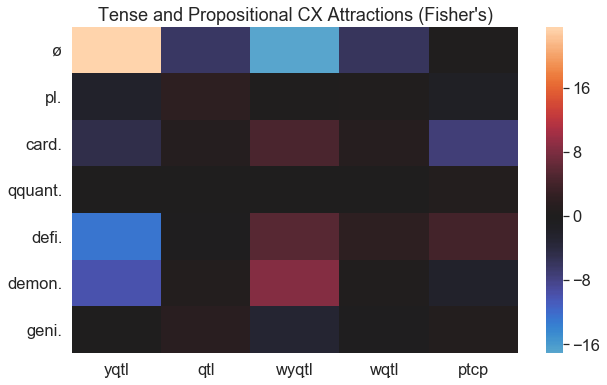

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(tense_assoc, center=0, robust=True)
plt.yticks(rotation=0)
plt.savefig(fg_path('tense_propcx_attractions.png'), dpi=300, bbox_inches='tight')
plt.title('Tense and Propositional CX Attractions (Fisher\'s)')
plt.show()

### ΔP Asymmetrical Tests

> "􏰁P is the probability of the outcome given the cue P(O|C) minus the probability of the outcome in the absence of the cue P(O|–C). When these are the same, when the outcome is just as likely when the cue is present as when it is not, there is no covariation between the two events and 􏰁P 1⁄4 0. 􏰁P approaches 1.0 as the presence of the cue increases the likelihood of the outcome and approaches –1.0 as the cue decreases the chance of the outcome—a negative association." -Ellis, "Language Acquisition," 2006, 11.

**NB: The following code needs to be checked over.**

#### Propositional CX as cue

In [42]:
# # unidirectional ΔP test
# con = contingency_table(tense_cols)
# dp_a, dp_b, dp_c, dp_d = [con[x] for x in ('a', 'b', 'c', 'd')]
# cx_cue = dp_a / (dp_a + dp_c) - dp_b / (dp_b + dp_d)

In [43]:
# cx_cue

#### Verb as Cue

In [44]:
# # unidirectional ΔP test
# con = contingency_table(tense_cols)
# dp_a, dp_b, dp_c, dp_d = [con[x] for x in ('a', 'b', 'c', 'd')]
# verb_cue = dp_a / (dp_a + dp_b) - dp_c / (dp_c + dp_d)

In [45]:
# verb_cue